In [1]:
import os; import pandas as pd; import numpy  as np
from pandas.tseries.offsets import *
import statsmodels.formula.api as smf
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [24]:
path = "../data/tpl/lines_events/"
tra  = pd.read_parquet(path+"traffic.parquet")

## Traffic over Time

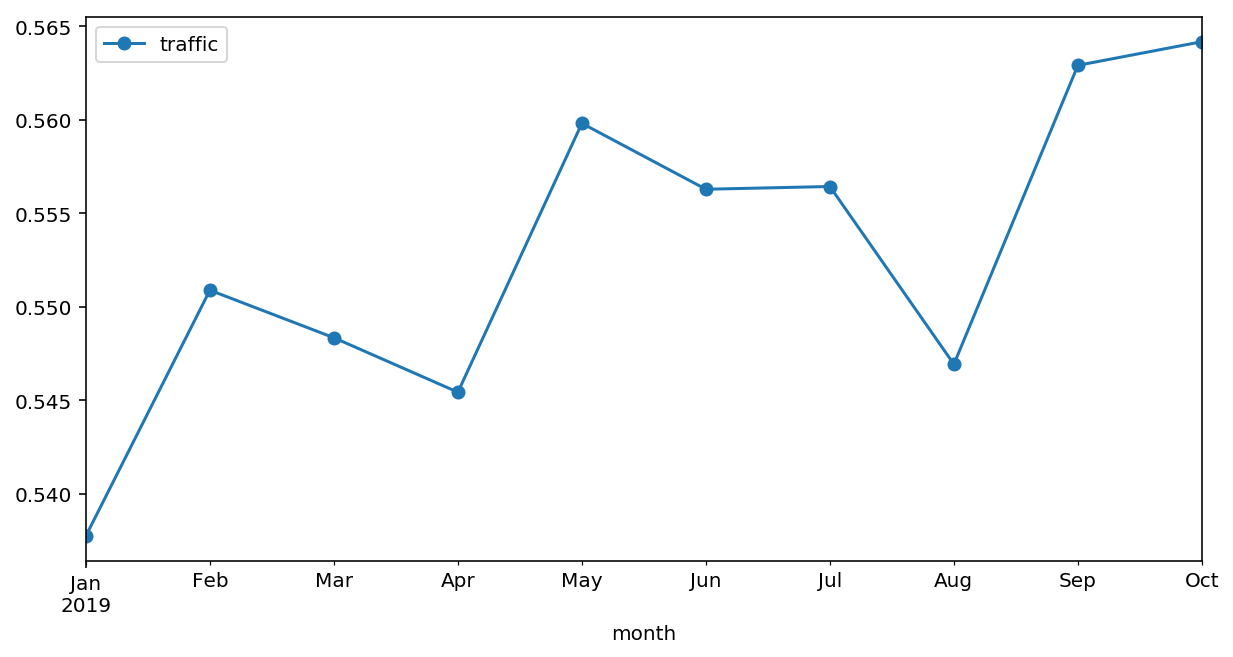

In [3]:
ds = tra.copy()
ds = ds[ds.index.get_level_values(2)>=pd.datetime(2019,1 ,1)]
ds = ds[ds.index.get_level_values(2)<=pd.datetime(2019,10,1)].copy()
ds['month'] = ds.index.get_level_values(2).to_period('M').to_timestamp('M')
fig, ax1 = plt.subplots(1,1, figsize=(10,5))
ds.groupby(['month'])[['traffic']].mean().plot(ax=ax1, marker='o');

## Nationalities of Visiting People

In [25]:
nat = pd.read_csv("../analysis/nationalities_incoming.csv", parse_dates=['Date']).set_index('Date')
tra = tra.reset_index().set_index('date')
tra[nat.columns] = nat
tra = tra.reset_index().set_index(['fermata', 'weekend', 'date', 'hour'])

peo = pd.read_csv("../analysis/people_total.csv", parse_dates=['date']).set_index(['date', 'hour'])
tra = tra.reset_index()
tra['hour'] = tra['hour'].astype(int)
tra = tra.set_index(['date','hour'])
tra[peo.columns] = peo
tra = tra.reset_index().set_index(['fermata', 'weekend', 'date', 'hour'])

In [38]:
ds = tra.dropna().copy()
ds['tot_car'] = ds['Road'] + ds['Highway']

for col in nat.columns:
    ds[col] = ds[col] * ds['tot_car'] / 100
    
    # Standardize
    ds[col] = ds[col] / ds[col].std() 

In [55]:
print('All days')
reg = smf.ols(" traffic ~ Italy + Switzerland", ds.groupby(['date', 'hour']).mean()).fit()
print("R-squared: {0:1.2f}%, N: {1:1,.0f}".format(reg.rsquared*100, reg.nobs))
reg.summary().tables[1]

All days
R-squared: 3.30%, N: 467


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.9441,0.366,-2.578,0.010,-1.664,-0.224
Italy,-0.0159,0.007,-2.376,0.018,-0.029,-0.003
Switzerland,0.0208,0.005,3.955,0.000,0.010,0.031


### ...

In [ ]:
print('Weekdays Only')
reg = smf.ols(" traffic ~ Italy*weekend", ds.reset_index()).fit()
print("R-squared: {0:1.2f}%, N: {1:1,.0f}".format(reg.rsquared*100, reg.nobs))
reg.summary().tables[1]

## Weather and Air Pollution

In [41]:
wea = pd.read_csv("../analysis/air-weather-info.csv", parse_dates=['day'])
wea = wea.set_index(['day', 'hour']).drop(['Ora', 'Data', 'Data e ora'],axis=1)
wea.rename({'Prec. [mm]':'prec', 'Temp. [°C]':'temp'},axis=1, inplace=True)

In [42]:
tra = tra.reset_index()
tra['hour'] = tra['hour'].astype(int)
tra = tra.set_index(['date', 'hour'])
tra[wea.columns] = wea
tra = tra.reset_index().set_index(['fermata', 'weekend', 'date', 'hour'])
ds = tra.copy()

In [43]:
print('All days')
reg = smf.ols(" traffic ~ prec + temp", ds.groupby(['date', 'hour']).mean()).fit()
print("R-squared: {0:1.2f}%, N: {1:1,.0f}".format(reg.rsquared*100, reg.nobs))
reg.summary().tables[1]

All days
R-squared: 2.77%, N: 6,433


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4592,0.005,100.355,0.000,0.450,0.468
prec,-0.0026,0.015,-0.177,0.859,-0.031,0.026
temp,0.0037,0.000,13.516,0.000,0.003,0.004


## Hotel Guests

In [44]:
hot = pd.read_csv("../analysis/hotel_guests.csv", parse_dates=['date']).set_index('date')
tra = tra.reset_index().set_index(['date'])
tra['hotel_guests'] = hot
tra = tra.reset_index().set_index(['fermata', 'weekend', 'date', 'hour'])
ds = tra.copy()

In [45]:
print('All days')
reg = smf.ols(" traffic ~ hotel_guests", ds.groupby(['date']).mean()).fit()
print("R-squared: {0:1.2f}%, N: {1:1,.0f}".format(reg.rsquared*100, reg.nobs))
reg.summary().tables[1]

All days
R-squared: 1.88%, N: 318


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.5229,0.010,53.810,0.000,0.504,0.542
hotel_guests,5.911e-05,2.4e-05,2.458,0.015,1.18e-05,0.000


## Parkings

In [46]:
par = pd.read_csv("../analysis/parking-info.csv", parse_dates=['data']).drop(['Unnamed: 0'],axis=1)
par = par.set_index(['data', 'hour'])

In [47]:
tra = tra.reset_index()
tra = tra.set_index(['date', 'hour'])
tra['parkings'] = par.groupby(['data', 'hour'])['OccupazionePerc'].mean()
tra = tra.reset_index().set_index(['fermata', 'weekend', 'date', 'hour'])
ds = tra.copy()

In [48]:
ds = ds[ds.index.get_level_values(2)>=pd.datetime(2019,1 ,1)]
ds = ds[ds.index.get_level_values(2)<=pd.datetime(2019,10,1)].copy()
ds = ds.dropna(subset=['parkings'])

In [49]:
print('All days')
reg = smf.ols(" traffic ~ parkings", ds.groupby(['date','hour']).mean()).fit()
print("R-squared: {0:1.2f}%, N: {1:1,.0f}".format(reg.rsquared*100, reg.nobs))
reg.summary().tables[1]

All days
R-squared: 19.88%, N: 1,971


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.3719,0.008,49.076,0.000,0.357,0.387
parkings,0.0040,0.000,22.105,0.000,0.004,0.004


## All Together

In [67]:
var = [
    'Italy', 'Switzerland', #'Germany', 'Netherlands',
    'prec','temp',
    'hotel_guests',
    'parkings',
]

ds = tra.dropna(subset=var).groupby(['date', 'hour']).mean()

print('All days')
reg = smf.ols(" traffic ~ {0}".format(" + ".join(var)), ds).fit()
print("R-squared: {0:1.2f}%, N: {1:1,.0f}".format(reg.rsquared*100, reg.nobs))
reg.summary().tables[1]

All days
R-squared: 4.09%, N: 827


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.4708,0.251,-1.877,0.061,-0.963,0.022
Italy,0.0030,0.004,0.777,0.438,-0.005,0.011
Switzerland,0.0109,0.003,3.472,0.001,0.005,0.017
prec,-0.0066,0.024,-0.275,0.784,-0.054,0.041
temp,0.0049,0.001,5.332,0.000,0.003,0.007
hotel_guests,3.059e-06,5.04e-05,0.061,0.952,-9.59e-05,0.000


## Coordinates

In [38]:
bus = pd.read_parquet("../data/tpl/lines_events/bus_lugano.parquet")
bus = bus.groupby(['fermata'])[['posizione']].first()

In [42]:
import geopandas as gpd
data = gpd.read_file("/Users/abramo/Repos/USI-Hackathon-2019/data/data/tpl/gis/stops/tpl_stops.shp")

data = data.to_crs(epsg=4326)[['fermata', 'geometry']]
data['lat'] = data['geometry'].astype(str).str[ 7:21].astype(float)
data['lon'] = data['geometry'].astype(str).str[25:39].astype(float)

data = data.set_index('fermata')

In [39]:
bus['posizione'] = bus['posizione'].astype(str).str[:4]
bus['posizione'] = bus['posizione'].astype(int)

In [45]:
bus = bus.reset_index().set_index('posizione')
bus['lat'] = data['lat']
bus['lon'] = data['lon']
bus = bus.reset_index().set_index('fermata')
bus.head()

,posizione,lat,lon
fermata,,,
Albonago Gradinata Mast 2,4259,8.972289,6.008947
Albonago Sentiero Castagni Mast 2,4254,8.974724,46.013021
Albonago Sentiero Cavan Mast 2,4261,8.972123,46.012913
Albonago Via Ruscello Mast 2,4260,8.971481,46.011017
Albonago ai Ronchi Mast 2,4252,8.973236,46.014810


In [46]:
tra = tra.reset_index().set_index(['fermata'])
tra['lat'] = bus['lat']
tra['lon'] = bus['lon']
tra = tra.reset_index().set_index(['fermata', 'weekend', 'date', 'hour'])

## Save

In [48]:
tra.to_csv("Traffic_Index.csv")

In [65]:
ds.index.get_level_values(0).unique()

DatetimeIndex(['2019-05-27', '2019-05-28', '2019-05-29', '2019-05-30',
               '2019-05-31', '2019-06-01', '2019-06-02', '2019-06-03',
               '2019-06-04', '2019-06-05', '2019-06-06', '2019-06-07',
               '2019-06-08', '2019-06-09', '2019-06-13', '2019-06-14',
               '2019-06-15', '2019-06-16', '2019-06-17', '2019-06-18',
               '2019-06-19', '2019-06-20', '2019-06-21', '2019-06-22',
               '2019-06-23', '2019-06-24', '2019-06-25', '2019-06-26',
               '2019-06-27', '2019-06-28', '2019-06-29', '2019-06-30',
               '2019-07-01', '2019-07-02', '2019-07-03', '2019-07-04',
               '2019-07-05', '2019-07-06', '2019-07-07', '2019-07-08',
               '2019-07-09', '2019-07-13', '2019-07-14'],
              dtype='datetime64[ns]', name='date', freq=None)

In [73]:
tra = pd.read_csv("/Users/abramo/Repos/USI-Hackathon-2019/Traffic Index/Traffic_Index.csv.zip")
tra.columns

Index(['fermata', 'weekend', 'date', 'hour', 'dur', 'dur_p', 'benchmark',
       'benchmark_p', 'traffic', 'traffic_p', 'sensi', 'high', 'Germany',
       'Italy', 'Netherlands', 'Switzerland', 'Date', 'Total', 'Train', 'Road',
       'Highway', 'Commute', 'Non-commute', 'lat', 'lon'],
      dtype='object')

In [76]:
tra[['date','hour', 'lon', 'lat', 'traffic']].to_csv("lon_lat.csv")

In [78]:
tra

,fermata,weekend,date,hour,dur,dur_p,benchmark,benchmark_p,traffic,traffic_p,...,Switzerland,Date,Total,Train,Road,Highway,Commute,Non-commute,lat,lon
0,Cassarate- Lanchetta- Mast 2,0,2018-01-11,6,1.011111,1.833333,1.020833,1.5,0.000000,0.222222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.965803,46.006026
1,Cassarate- Lanchetta- Mast 2,0,2018-01-11,7,1.355556,1.666667,1.020833,1.5,0.327891,0.111111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.965803,46.006026
2,Cassarate- Lanchetta- Mast 2,0,2018-01-11,8,1.116667,1.666667,1.020833,1.5,0.093878,0.111111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.965803,46.006026
3,Cassarate- Lanchetta- Mast 2,0,2018-01-11,9,1.350000,1.666667,1.020833,1.5,0.322449,0.111111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.965803,46.006026
4,Cassarate- Lanchetta- Mast 2,0,2018-01-11,10,1.272222,1.666667,1.020833,1.5,0.246259,0.111111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.965803,46.006026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1438718,Pazzallo- Senago- Mast 2,1,2019-12-08,11,0.633333,0.500000,0.516667,0.5,0.225806,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.936380,45.983309
1438719,Pazzallo- Senago- Mast 2,1,2019-12-08,13,0.666667,0.500000,0.516667,0.5,0.290323,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.936380,45.983309
1438720,Pazzallo- Senago- Mast 2,1,2019-12-08,16,0.583333,0.500000,0.516667,0.5,0.129032,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.936380,45.983309
1438721,Pazzallo- Senago- Mast 2,1,2019-12-08,17,0.533333,0.500000,0.516667,0.5,0.032258,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.936380,45.983309
